# Week 3 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [2]:
noise = 0.2

#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

In [3]:
# 10 Artificially Generated Data

#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(0.5))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(0.2))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(0.9))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise = 0.2, numPerCategory = 200, innerRad = .7))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise = 0.2, numPerCategory = 500, innerRad = .2))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise = 0.7, numPerCategory = 500, innerRad = .7))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise = 0.7, numPerCategory = 300, centers = 3))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise = 0.2, numPerCategory = 500, centers = 5))
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise = 0.5, numPerCategory = 100, centers = 10))

We can easily visualize the rendered datasets because they are generated in two dimensions.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

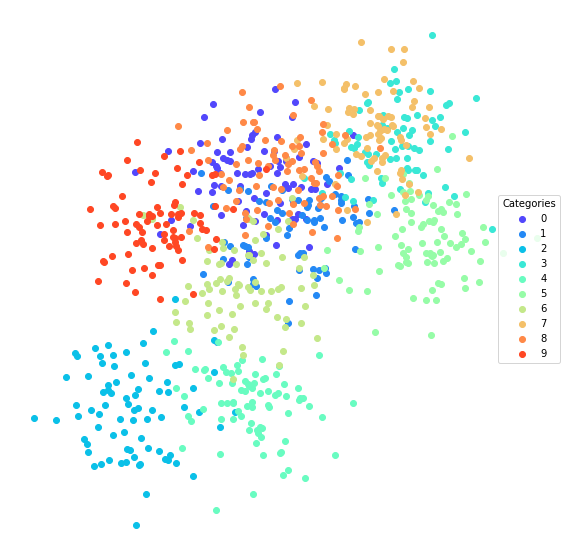

In [4]:
lucem_illud_2020.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [5]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [6]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [7]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.110,0.589133,0.333333,0.144074,0.222222
1,0.125,0.666446,0.526316,0.282429,0.384615
2,0.020,0.948927,0.909091,0.836446,0.909091
3,0.125,0.718023,0.560000,0.350000,0.500000
4,0.015,0.941697,0.941176,0.846601,0.888889
5,0.020,0.950355,0.785714,0.725238,0.916667
6,0.135,0.636111,0.333333,0.181667,0.350000
7,0.115,0.677377,0.400000,0.223421,0.421053
8,0.150,0.667277,0.285714,0.176984,0.444444


This lets us look at which classes do better:

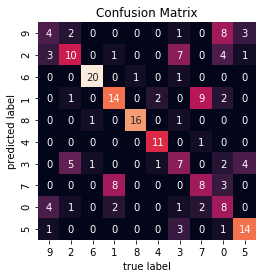

In [8]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

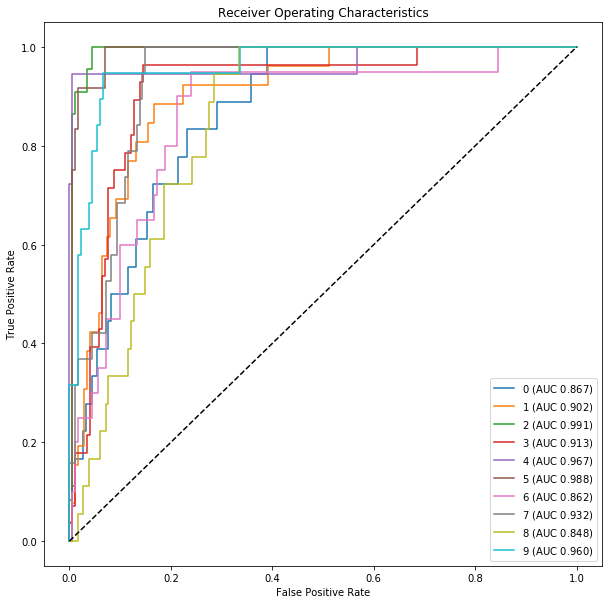

In [9]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

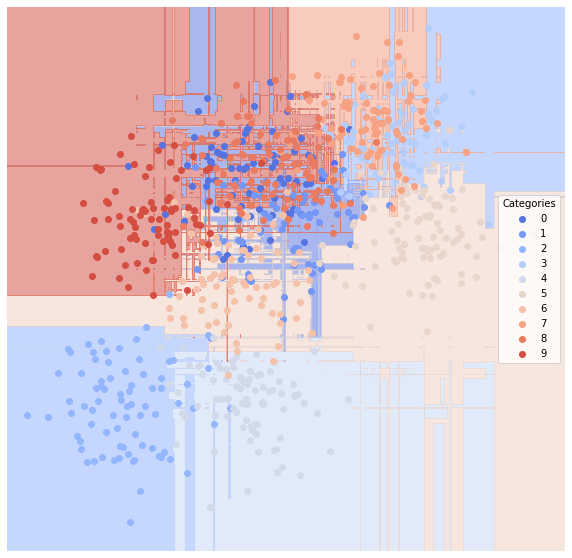

In [10]:
lucem_illud_2020.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [11]:
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Spam
Loading Ham
Converting to vectors


In [12]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()

In [13]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [14]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
spam,0.116959,0.624425,0.838710,0.325555,0.257426
not spam,0.116959,0.624425,0.885145,0.884864,0.991424


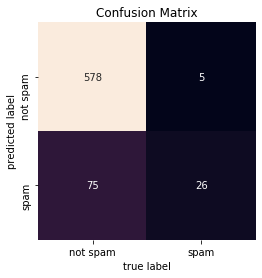

In [15]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

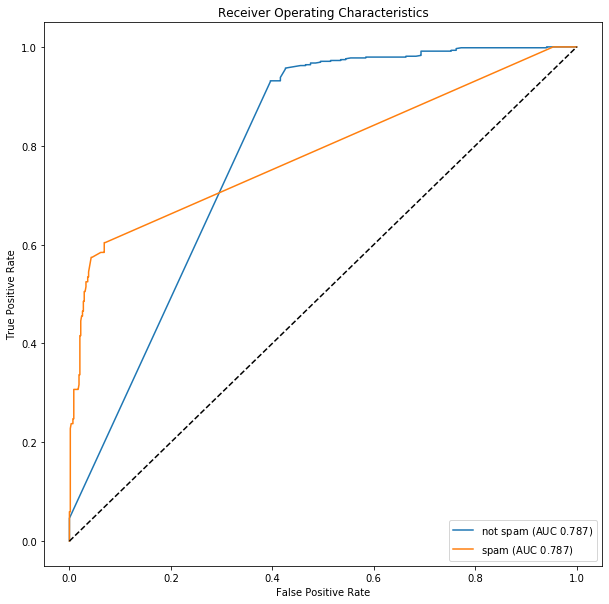

In [16]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


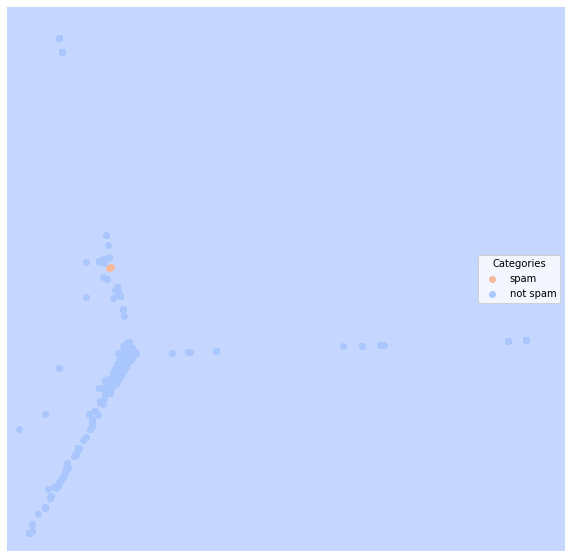

In [17]:
lucem_illud_2020.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

### Artificial Datasets

Most models did decently for the linear split data. Notably, the linear SVM and logistic regression models works the best with the linear spilt data even with noise of 0.5. This is because it is able to linearly divide the data into the two halves ignoring the noise. However, they do not do so well with the opposite split or target data where the data is not linearly separable with a line.

The naive baiyes classifier did well with linear split data and the target data. It is able to linearly separate data and also able to detect clustered area in the target data both when the radius is large and small. This is because the algorithm compares the probability of whether the data point is more likely in one subspace to the other. 

SVM using polynomial kernel worked the best with the target data when the degree was 2. It was able to capture the inner circle cluster of points and separate it from the outer circle. However when the degree is set to other numbers, this SVM model no longer worked well. The degree of 2 allowed it to fit the model to the circle clusters in the data.

K nearest neighbor did well for both the X-split and target data, however less so when there is more noise. Since this algorithm classifies by finding other data points close to it, it separates the variable space non-linearly and is able to detect data clusters in different areas of the variable space. Where there is more noise, the model appears to be overfitting to the training data.

Decision Tree, random forest as well as gradient boosting using decision trees also did well for the X-split and target data, according to the evaluation metrics. These algorithms segments the variable space into rectangles. Hence it is able to detect data on opposite sides of the X-split as well as to form a jagged area around the inner circle cluster to split the circular data points. Random forest and gradient boosting did particularly well even though there was a noise of 0.9 for the X-split data, likely because these are ensemble models allowing finer splits in the model to classify in spite of the noise. This however seems to be very dangerous to overfitting.

While most models also have decent performance with multiple clusters, the k nearest neighbors, decision trees have a large variance of performance for the different classes as number of classes increased.

Neural Network also did well with the X-split data with low and high noise and target data. This model was able to divide the variable space smoothly to identify where the different classes are and does not seem to overfit to the data points of the training set, unlike the tree-based models.

None of the classifiers worked well for random data. This is because the data is all noise and the classes are not distinguishable from each other.


### Empirical Datasets

Reddit threads "classified" by thread topic performed well with most of the models. In particular, the best models are Linear SVM, Logistic Regression as well as neural networks because there were 3 clusters that were almost linearly separable and the last cluster that added noise to the class distinctions. Naive Bayes, Random Forest and Gradient boosting also performed decently for this data likely because of the distinguishable clusters of data.

20 newsgroups "classified" by group topic: the linear SVM and logistics regression models as well as the neural networks distinguished the clusters best. This is because of the 4 clusters had distinguishable mutually exclusive areas with some overlap between the for sale and mac hardware topics.

For the Senate press releases "classified" by Senator (2 senators), again most models performed well for this data. Sepcifically, the linear SVM, logistic regression, decision tree, gradient boosting and random forest were achieved predictions that were close to perfect. This is likely because the data only had 2 classes and were pretty distinguishable lending to the best performance of the simple models.

Different from the previous 3 datasets, the Senate press releases "classified" by Senator (5 senators) had 5 classes that were not mostly overlapping each other. The best models for this data include random forest and gradient boosting likely due the the complexity of the overlapping data that led to ensemble models performing better.

Finally, the Emails classified as Spam or Ham data produced the most varied results for the different models because of the low number of spam compared to non-spam datapoints. Considering this is a spam detection problem and assuming we are looking to reduce the number of spams in our email, the models that produced the highest recall for spam classification is the Naive Bayes and Neural network models. This is likely due to the algorithm of classification fit with the data, since this data does not really have a distinguishable variable space for each class.

### New Classifier

In [18]:
# one artificial dataset
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one

# one empirical dataset
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

In [19]:
# one new classifier
clf = sklearn.ensemble.AdaBoostClassifier(n_estimators=100)

In [20]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)

In [21]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.54,0.46,0.461538,0.481538,0.48
1,0.54,0.46,0.458333,0.481667,0.44


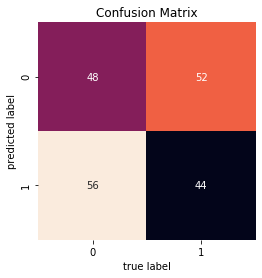

In [22]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

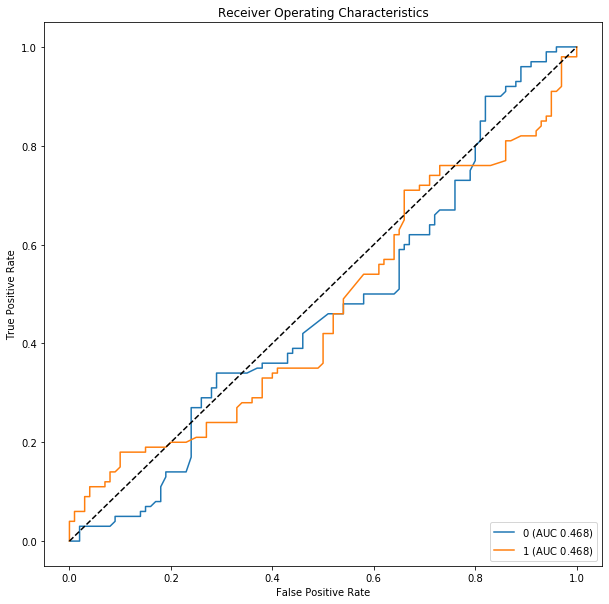

In [23]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


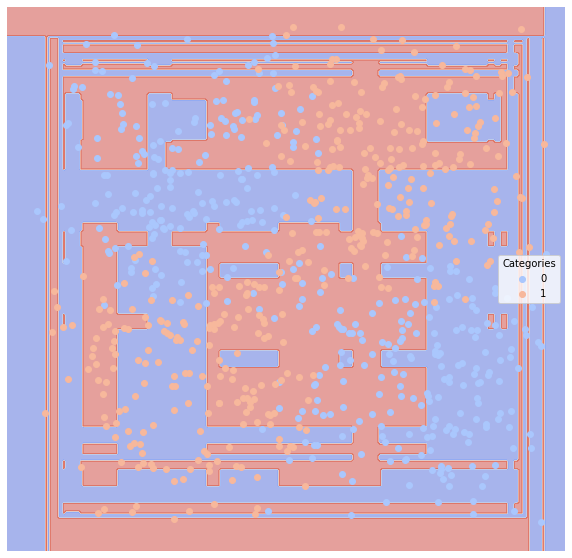

In [24]:
lucem_illud_2020.plotregions(clf, dfTrain)

The Adaboost model did not do well on the X-split data and detecting spam with low recall for the spam category. In the former data, we see that the base on decision trees did not segment the data ideally into the 4 quadrants, but instead is likely to overfit the data. In the latter case, this is likely due to the use of decision trees as the base classifier by default that is a mismatch to this data, since the spam category is overlapping onto the non-spam category.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [25]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

Let's turn the 'targetSenator' column into a binary category variable.

In [26]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

In [27]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator,category
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama,True
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama,True
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama,True
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama,True
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama,True
5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Dec2007Obama192.txt,raw/Obama/10Dec2007Obama192.txt,Statement of Senator Barack Obama on Intern...,Obama,True
6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2007Obama472.txt,raw/Obama/10Jan2007Obama472.txt,Legislation to Increase Availability and Us...,Obama,True
7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2008Obama165.txt,raw/Obama/10Jan2008Obama165.txt,Obama Statement on the Flooding in East Cen...,Obama,True
8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jul2008Obama28.txt,raw/Obama/10Jul2008Obama28.txt,Obama Green Applaud House Passage of Bill ...,Obama,True
9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jul2008Obama29.txt,raw/Obama/10Jul2008Obama29.txt,Obama Joins Schumer and McCaskill to Call o...,Obama,True


Tokenize and normalize

In [28]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [29]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator,category,tokenized_text,normalized_text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama,True,"[Obama, Calls, on, IRS, to, Protect, Taxpayers...","[obama, call, irs, protect, taxpayer, privacy,..."
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama,True,"[Statement, from, Senator, Barack, Obama, on, ...","[statement, senator, barack, obama, dodd, shel..."
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama,True,"[Obama, Says, Bill, Will, Help, Cut, Off, Supp...","[obama, say, bill, help, cut, supply, dangerou..."
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama,True,"[Obama, Durbin, Say, Illinois, Will, Receive, ...","[obama, durbin, illinois, receive, percent, fu..."
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama,True,"[Obama, Introduces, Bill, to, Help, Tap, Power...","[obama, introduce, bill, help, tap, power, gen..."
5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Dec2007Obama192.txt,raw/Obama/10Dec2007Obama192.txt,Statement of Senator Barack Obama on Intern...,Obama,True,"[Statement, of, Senator, Barack, Obama, on, In...","[statement, senator, barack, obama, internatio..."
6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2007Obama472.txt,raw/Obama/10Jan2007Obama472.txt,Legislation to Increase Availability and Us...,Obama,True,"[Legislation, to, Increase, Availability, and,...","[legislation, increase, availability, use, ren..."
7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2008Obama165.txt,raw/Obama/10Jan2008Obama165.txt,Obama Statement on the Flooding in East Cen...,Obama,True,"[Obama, Statement, on, the, Flooding, in, East...","[obama, statement, flooding, east, central, il..."
8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jul2008Obama28.txt,raw/Obama/10Jul2008Obama28.txt,Obama Green Applaud House Passage of Bill ...,Obama,True,"[Obama, Green, Applaud, House, Passage, of, Bi...","[obama, green, applaud, house, passage, bill, ..."
9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jul2008Obama29.txt,raw/Obama/10Jul2008Obama29.txt,Obama Joins Schumer and McCaskill to Call o...,Obama,True,"[Obama, Joins, Schumer, and, McCaskill, to, Ca...","[obama, join, schumer, mccaskill, justice, dep..."


Let's split the data into training data and testing data.

In [30]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [31]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [32]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

In [33]:
TFVects

<1368x11417 sparse matrix of type '<class 'numpy.float64'>'
	with 137092 stored elements in Compressed Sparse Row format>

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [34]:
TFVects.shape

(1368, 11417)

We can save this in the dataframe to make things easier

In [35]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [36]:
train_data_df[:2]

,download_url,html_url,name,path,text,targetSenator,category,tokenized_text,normalized_text,vect
240,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,19Oct2007Obama244.txt,raw/Obama/19Oct2007Obama244.txt,Obama Demands Investigation into Subprime L...,Obama,True,"[Obama, Demands, Investigation, into, Subprime...","[obama, demand, investigation, subprime, loan,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1284,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16Jul2007Clinton575.txt,raw/Clinton/16Jul2007Clinton575.txt,July 16 2007 Senator Clinton Joins Local Farm...,Clinton,False,"[July, 16, 2007, Senator, Clinton, Joins, Loca...","[july, senator, clinton, join, local, farmer, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [37]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [38]:
train_data_df['pca'] = [r for r in reduced_data]

In [39]:
train_data_df[:2]

,download_url,html_url,name,path,text,targetSenator,category,tokenized_text,normalized_text,vect,pca
240,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,19Oct2007Obama244.txt,raw/Obama/19Oct2007Obama244.txt,Obama Demands Investigation into Subprime L...,Obama,True,"[Obama, Demands, Investigation, into, Subprime...","[obama, demand, investigation, subprime, loan,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.006279104886651005, -0.021376031140243085, ..."
1284,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16Jul2007Clinton575.txt,raw/Clinton/16Jul2007Clinton575.txt,July 16 2007 Senator Clinton Joins Local Farm...,Clinton,False,"[July, 16, 2007, Senator, Clinton, Joins, Loca...","[july, senator, clinton, join, local, farmer, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.08197223629393666, -0.06855403077061673, 0...."


Visualization in 2D:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


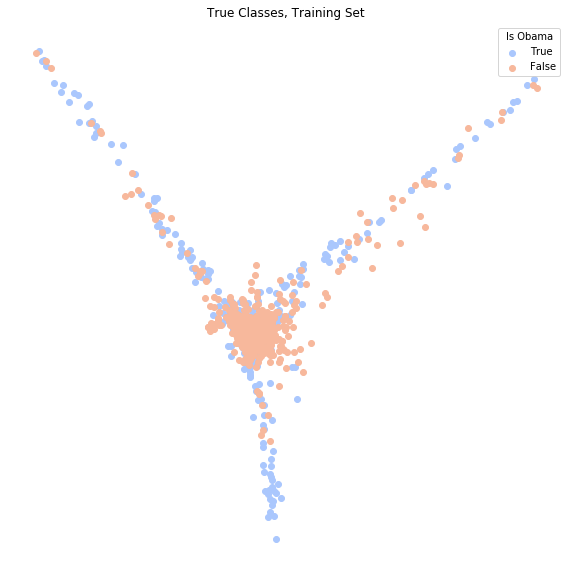

In [40]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

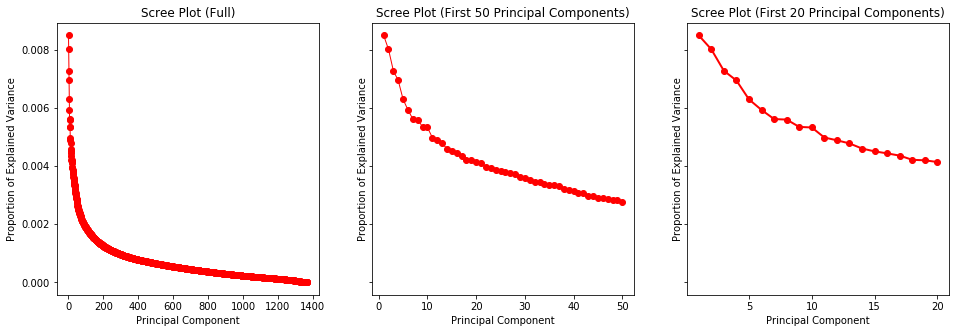

In [41]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 20 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [42]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [43]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [44]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6571637426900585

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [45]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6422287390029325

Slightly poorer. How about using more dimensions (40)?

In [46]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7317251461988304
Testing:
0.7038123167155426


Or still more (100)?

In [47]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8230994152046783
Testing:
0.7917888563049853


Or even more (200)!

In [48]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.868421052631579
Testing:
0.8123167155425219


This is becoming ridiculous (400)!

In [49]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9049707602339181
Testing:
0.8387096774193549


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [50]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9634502923976608


Train the model using training data, and then test it on the testing data.

In [51]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8387096774193549


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [52]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [53]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9707602339181286
Testing:
0.8885630498533724


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [54]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [55]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.9130434782608695

Recall:

In [56]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.8289473684210527

F1-measure:

In [57]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8689655172413793

Let's take a look at how well our posterior distribution looks relative to the truth.

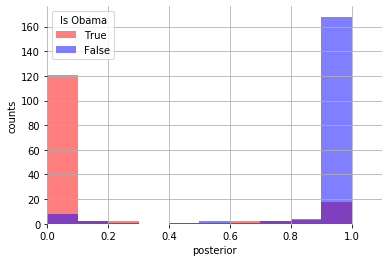

In [58]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [59]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,signature,-2.178943,5566,-1.720979
1,welcomed,-2.246384,amy,-1.782855
2,island,-2.318704,dick,-1.848813
3,read,-2.369998,brundage,-1.860241
4,growing,-2.383243,affairs,-2.008661
5,fy,-2.396666,chicago,-2.008661
6,urging,-2.410272,temporary,-2.215276
7,ground,-2.424065,interests,-2.248612
8,honor,-2.438051,location,-2.265706
9,point,-2.438051,reform,-2.300798


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [60]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [61]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [62]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [63]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [64]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [65]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [66]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [67]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.8920487521764364


In [68]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
1020,sci.space,sci.space
2109,comp.graphics,soc.religion.christian
664,soc.religion.christian,soc.religion.christian
2145,comp.graphics,comp.graphics
1094,sci.space,sci.space
1400,sci.space,sci.space
1997,comp.graphics,comp.graphics
1414,sci.space,sci.space
795,soc.religion.christian,soc.religion.christian
1594,comp.graphics,comp.graphics


Looks pretty good, lets examine the testing dataset:

In [69]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7674418604651163


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

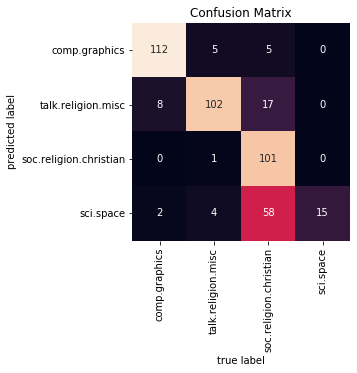

In [70]:
lucem_illud_2020.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [71]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #F-1 measure

0.8455298636221802
0.7674418604651163
0.7405118449020035


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [72]:
lucem_illud_2020.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
sci.space,0.081395,0.885073,0.910714,0.789579,0.803150
talk.religion.misc,0.148837,0.594937,1.000000,0.338711,0.189873
soc.religion.christian,0.188372,0.873147,0.558011,0.554866,0.990196
comp.graphics,0.046512,0.942783,0.918033,0.866040,0.918033


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

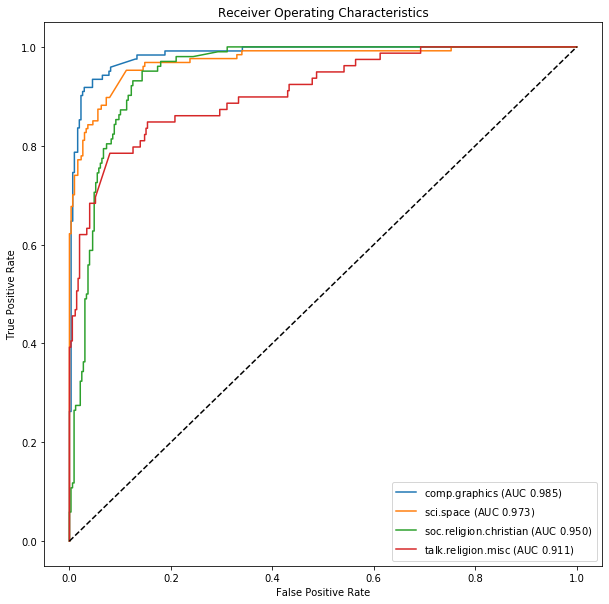

In [73]:
lucem_illud_2020.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

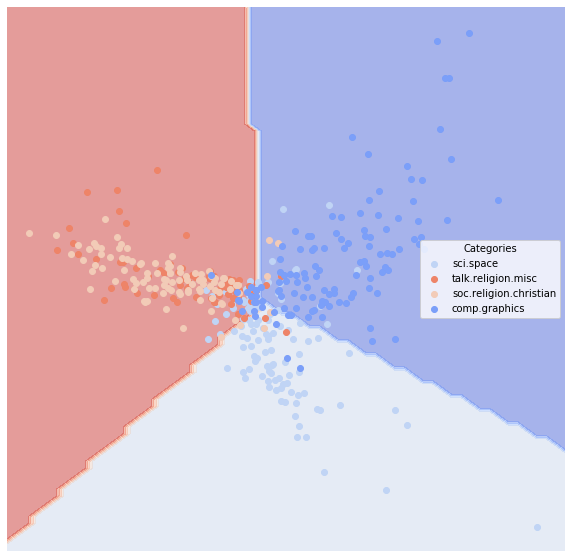

In [74]:
lucem_illud_2020.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


### Data preparation

In [75]:
data_raw = pandas.read_csv('../../Project/Data/hate-speech-and-offensive-language-master/data/labeled_data.csv', index_col=0)
data_raw.rename({'class':'category'}, axis='columns', inplace=True)
#24,783 instances
#data['category'].replace({0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}, inplace=True)
# Source: https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data

text_col = 'tweet'
vec_col = 'vect'
label_col = 'category'
#0 - hate speech, 1 - offensive language, 2 - neither

# use the first 5000 to train
data = data_raw[:5000]

In [76]:
data[:10]

,count,hate_speech,offensive_language,neither,category,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [77]:
# Tokenize and Normalize
data['tokenized_text'] = data[text_col].apply(lambda x: lucem_illud_2020.word_tokenize(x))
data['normalized_text'] = data['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
data

,count,hate_speech,offensive_language,neither,category,tweet,tokenized_text,normalized_text
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[RT, @mayasolovely, As, a, woman, you, should,...","[rt, @mayasolovely, woman, complain, clean, ho..."
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[RT, @mleew17, boy, dats, cold, tyga, dwn, bad...","[rt, @mleew17, boy, dat, cold, tyga, dwn, bad,..."
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[RT, @UrKindOfBrand, Dawg, RT, @80sbaby4life, ...","[rt, @urkindofbrand, dawg, rt, @80sbaby4life, ..."
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[RT, @C_G_Anderson, @viva_based, she, look, li...","[rt, @c_g_anderson, @viva_based, look, like, t..."
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[RT, @ShenikaRoberts, The, shit, you, hear, ab...","[rt, @shenikarobert, shit, hear, true, faker, ..."
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...","[@T_Madison_x, The, shit, just, blows, me, cla...","[@t_madison_x, shit, blow, claim, faithful, so..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ...","[@__BrighterDays, I, can, not, just, sit, up, ...","[@__brighterdays, sit, hate, bitch, get, shit,..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,"[8220;@selfiequeenbri, cause, I, 'm, tired, of...","[8220;@selfiequeenbri, cause, m, tired, big, b..."
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...","[amp, you, might, not, get, ya, bitch, back, a...","[amp, ya, bitch, amp, s]"
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria...","[@rhythmixx, hobbies, include, fighting, Maria...","[@rhythmixx, hobby, include, fight, mariam, bi..."


In [79]:
# Create Train Test Sets
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(data, holdBackFraction=holdBackFraction)

In [80]:
print(len(train_data_df))
print(len(test_data_df))

4000
1000


In [81]:
train_data_df.groupby('category').size()
#0 - hate speech, 1 - offensive language, 2 - neither

category
0     319
1    3019
2     662
dtype: int64

In [82]:
test_data_df.groupby('category').size()
#0 - hate speech, 1 - offensive language, 2 - neither

category
0     71
1    744
2    185
dtype: int64

In [83]:
# Vectorize
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_train = TFVectorizer.fit_transform(train_data_df[text_col])
train_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_train.todense()]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


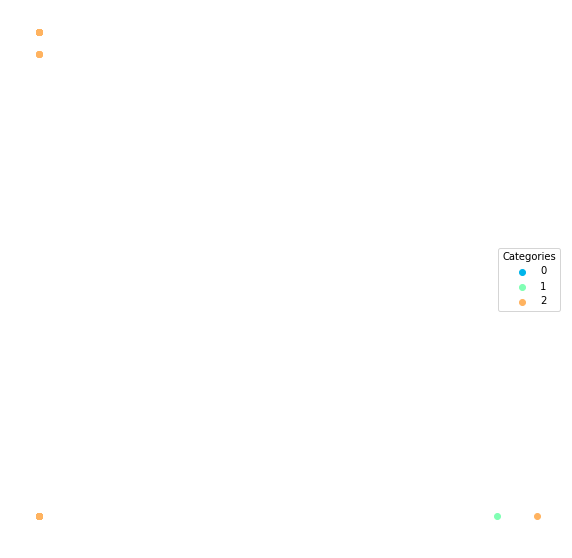

In [84]:
lucem_illud_2020.plotter(train_data_df)

### Logistic Regression

In [112]:
# Train LR
clf = sklearn.linear_model.LogisticRegression()

In [113]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [114]:
# Save Predictions
train_data_df['lr_predict'] = clf.predict(np.stack(train_data_df[vec_col], axis=0))
print("Training score:")
print(clf.score(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col]))

Training score:
0.85275


In [115]:
#Create vectors for test
TFVects_test = TFVectorizer.transform(test_data_df[text_col])
test_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['lr_predict'] = clf.predict(np.stack(test_data_df[vec_col], axis=0))

#Test
print("Testing score:")
print(clf.score(np.stack(test_data_df[vec_col], axis=0), test_data_df[label_col]))

Testing score:
0.806


In [116]:
train_data_df[[label_col, 'lr_predict']][:10]

,category,lr_predict
3898,1,1
1107,1,1
3314,2,2
4126,1,1
2270,1,1
4908,1,1
1826,0,1
70,2,1
329,1,1
4488,1,1


In [117]:
test_data_df[[label_col, 'lr_predict']][:10]

,category,lr_predict
3413,1,1
395,1,1
920,1,1
3890,1,1
2662,1,1
0,2,1
1791,1,1
1372,2,1
4236,1,1
1902,1,1


In [118]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.063,0.562842,0.900000,0.176085,0.126761
1,0.193,0.634577,0.799782,0.799108,0.987903
2,0.132,0.662046,0.873239,0.415653,0.335135


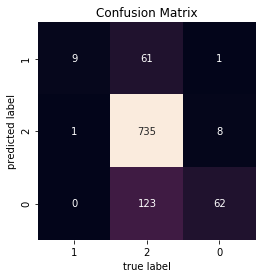

In [119]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

In [207]:
test_data_df.groupby('category').size()

category
0     71
1    744
2    185
dtype: int64

In [208]:
test_data_df.groupby('lr_predict').size()

lr_predict
0     10
1    919
2     71
dtype: int64

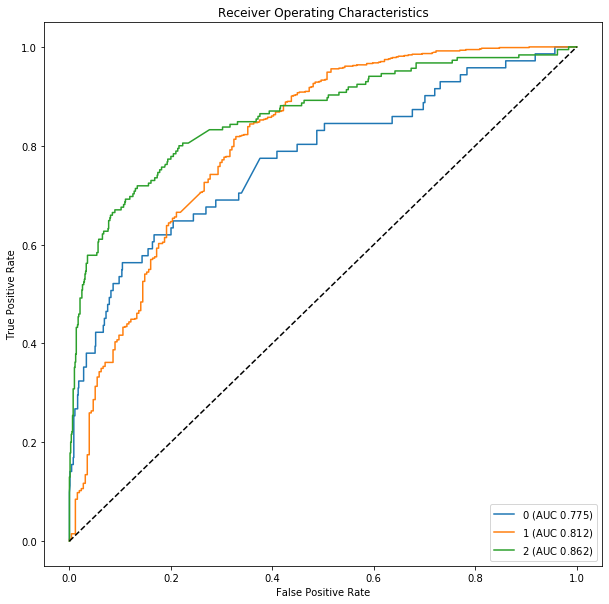

In [120]:
lucem_illud_2020.plotMultiROC(clf, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


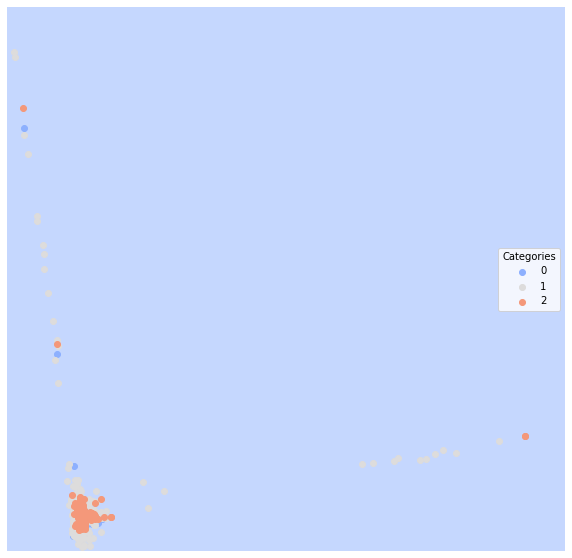

In [121]:
lucem_illud_2020.plotregions(clf, test_data_df)

In [122]:
extrapolation = data_raw[5000:][['tweet']]

In [123]:
#Create vectors for extrapolation
TFVects_out = TFVectorizer.transform(extrapolation[text_col])
extrapolation[vec_col] = [np.array(v).flatten() for v in TFVects_out.todense()]

#Add to df
extrapolation['lr_predict'] = clf.predict(np.stack(extrapolation[vec_col], axis=0))

In [124]:
extrapolation[[text_col, 'lr_predict']]

,tweet,lr_predict
5149,@TielerMLG @psvch @HalfAssed_ coming to the re...,1
5150,"@TimMurphyy @fgcu_basketball rather be an ""ult...",1
5151,"@TimoteoSHonesto @vcortesusmc little punk, we ...",1
5152,@TinnyTimm taylor wack ass bitch nigga,1
5153,@Titan21Mtzzz vegeta is a little bitch #TeamGoku,1
5154,@Titan21Mtzzz you is a hoe,1
5155,@Titan4Ever2488 how are Yankees games on the r...,2
5156,@Titan4Ever2488 how do Yankees fans look back ...,2
5157,@Titan4Ever2488 some Mets fan tried telling me...,2
5158,@TitsOfAnarchy \nI glads dis colored man cans ...,1


### Naive Bayes

In [97]:
# Train Naive Bayes
clf = sklearn.naive_bayes.MultinomialNB()

In [98]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [99]:
# Save Predictions
train_data_df['nb_predict'] = clf.predict(np.stack(train_data_df[vec_col], axis=0))
print("Training score:")
print(clf.score(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col]))

Training score:
0.8255


In [100]:
#Create vectors for test
TFVects_test = TFVectorizer.transform(test_data_df[text_col])
test_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['nb_predict'] = clf.predict(np.stack(test_data_df[vec_col], axis=0))

#Test
print("Testing score:")
print(clf.score(np.stack(test_data_df[vec_col], axis=0), test_data_df[label_col]))

Testing score:
0.783


In [101]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.071,0.500000,0.000000,0.071000,0.000000
1,0.217,0.576172,0.774194,0.774194,1.000000
2,0.146,0.605405,1.000000,0.356811,0.210811


In [106]:
test_data_df.groupby('category').size()

category
0     71
1    744
2    185
dtype: int64

In [102]:
test_data_df.groupby('nb_predict').size()

nb_predict
1    961
2     39
dtype: int64

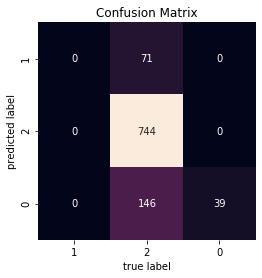

In [103]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

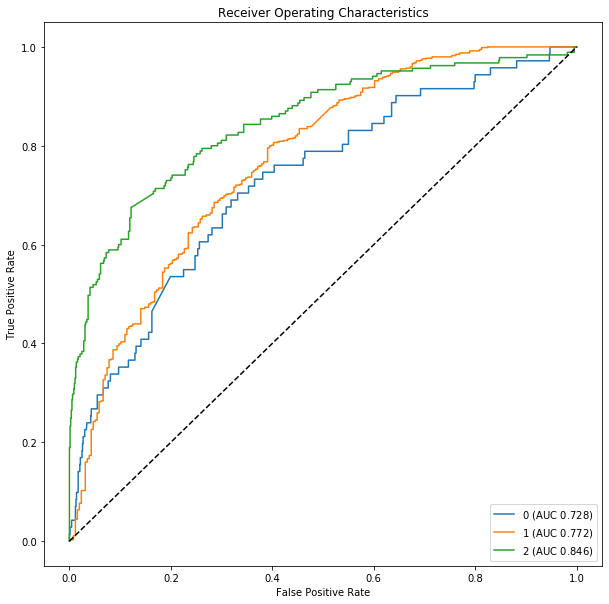

In [104]:
lucem_illud_2020.plotMultiROC(clf, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


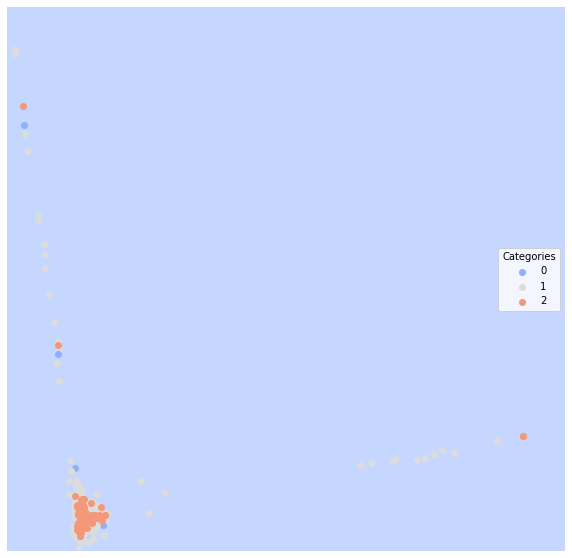

In [105]:
lucem_illud_2020.plotregions(clf, test_data_df)

In [108]:
#Create vectors for extrapolation
TFVects_out = TFVectorizer.transform(extrapolation[text_col])
extrapolation[vec_col] = [np.array(v).flatten() for v in TFVects_out.todense()]

#Add to df
extrapolation['nb_predict'] = clf.predict(np.stack(extrapolation[vec_col], axis=0))
extrapolation[[text_col, 'nb_predict']]

,tweet,nb_predict
5149,@TielerMLG @psvch @HalfAssed_ coming to the re...,1
5150,"@TimMurphyy @fgcu_basketball rather be an ""ult...",1
5151,"@TimoteoSHonesto @vcortesusmc little punk, we ...",1
5152,@TinnyTimm taylor wack ass bitch nigga,1
5153,@Titan21Mtzzz vegeta is a little bitch #TeamGoku,1
5154,@Titan21Mtzzz you is a hoe,1
5155,@Titan4Ever2488 how are Yankees games on the r...,1
5156,@Titan4Ever2488 how do Yankees fans look back ...,1
5157,@Titan4Ever2488 some Mets fan tried telling me...,1
5158,@TitsOfAnarchy \nI glads dis colored man cans ...,1


While the logistic regression model has high precision for all 3 categories, it only has high recall for category 1 (offensive speech). Similarly, multinomial naive bayes model has a high precision for cat 1 and 2 (offensive and neither) but only high recall for category 1. In this case, since avoiding false negatives seems more important in the detection of hate speech and offensive speech, both the recall performance matters more. Both models only performed well for recall in detecting offensive speech.

Looking at the distribution of labels in the train set, the good performance for the the offensive speech category can be attributed to it having much more observations in the data. This as well as how the instances are overlapping in vector space is likely the reason for the varied performance.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

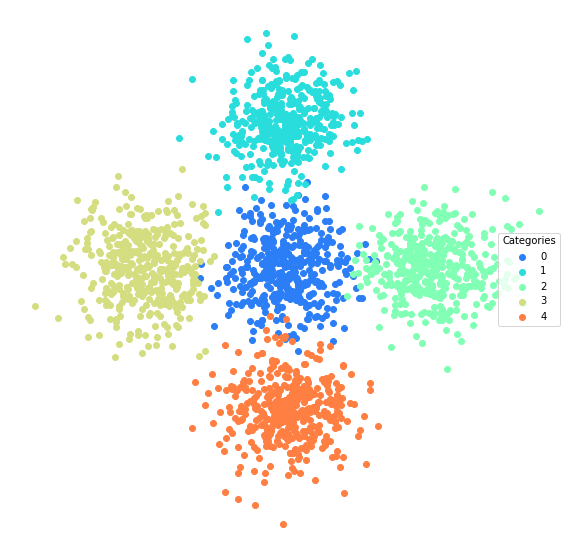

In [125]:
blobs_df = lucem_illud_2020.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud_2020.trainTestSplit(blobs_df)
lucem_illud_2020.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [126]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

To see what's going on visually with the classification: 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

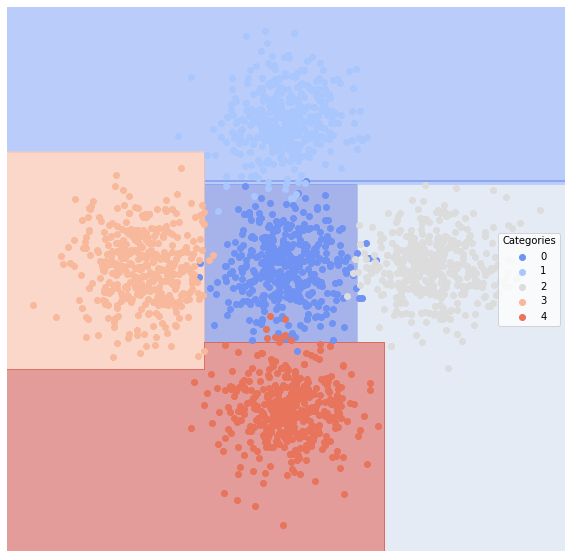

In [127]:
lucem_illud_2020.plotregions(clf_tree, df_exampleTree_train)

In [128]:
lucem_illud_2020.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.038,0.960429,0.858491,0.830344,0.957895
1,0.014,0.969044,0.989583,0.942796,0.940594
2,0.010,0.982500,0.979798,0.956404,0.970000
3,0.010,0.978551,0.989583,0.957600,0.959596
4,0.008,0.984448,0.990291,0.967997,0.971429


Lets look at accuracy:

In [129]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.96

What happens if we trim the tree?

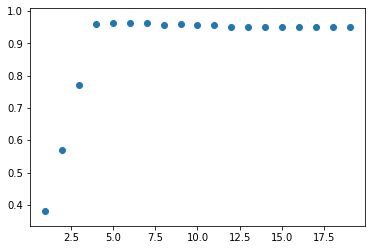

In [130]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [131]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [132]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

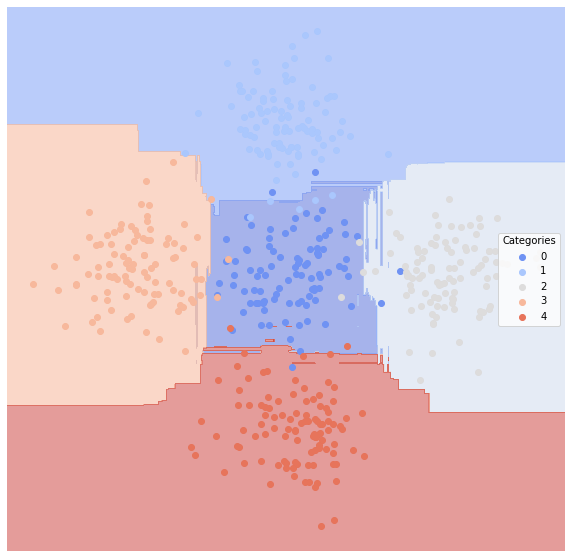

In [133]:
lucem_illud_2020.plotregions(bag, df_exampleTree_test)

In [134]:
lucem_illud_2020.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.038,0.956400,0.865385,0.829838,0.947368
1,0.016,0.971488,0.969697,0.931692,0.950495
2,0.010,0.982500,0.979798,0.956404,0.970000
3,0.008,0.979798,1.000000,0.967596,0.959596
4,0.008,0.984448,0.990291,0.967997,0.971429


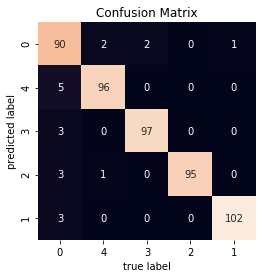

In [135]:
lucem_illud_2020.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

### Decision Tree

In [136]:
# Train Decision Tree
clf = sklearn.tree.DecisionTreeClassifier()

In [137]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [138]:
# Save Predictions
train_data_df['dt_predict'] = clf.predict(np.stack(train_data_df[vec_col], axis=0))
print("Training score:")
print(clf.score(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col]))

Training score:
0.99425


In [139]:
#Create vectors for test
TFVects_test = TFVectorizer.transform(test_data_df[text_col])
test_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['dt_predict'] = clf.predict(np.stack(test_data_df[vec_col], axis=0))

#Test
print("Testing score:")
print(clf.score(np.stack(test_data_df[vec_col], axis=0), test_data_df[label_col]))

Testing score:
0.782


In [140]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.097,0.596575,0.283333,0.121840,0.239437
1,0.207,0.714844,0.850980,0.837608,0.875000
2,0.132,0.770685,0.651429,0.472421,0.616216


In [146]:
test_data_df.groupby('category').size()

category
0     71
1    744
2    185
dtype: int64

In [141]:
test_data_df.groupby('dt_predict').size()

dt_predict
0     60
1    765
2    175
dtype: int64

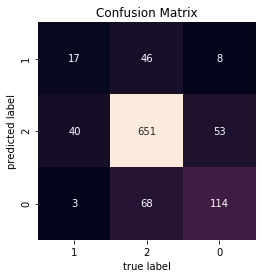

In [142]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

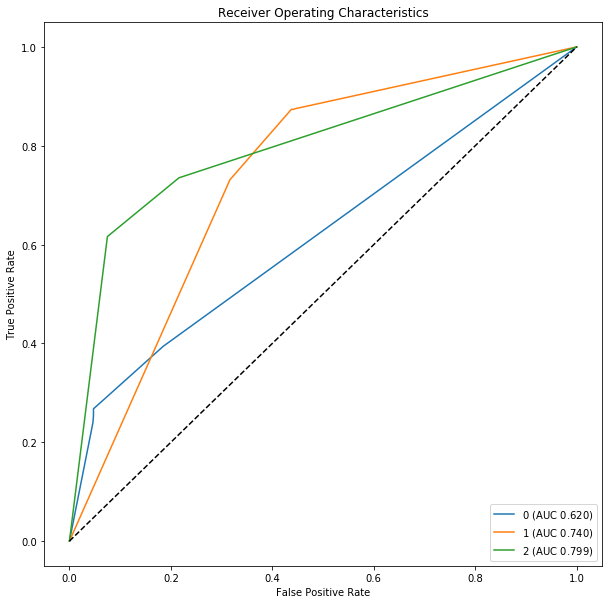

In [143]:
lucem_illud_2020.plotMultiROC(clf, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


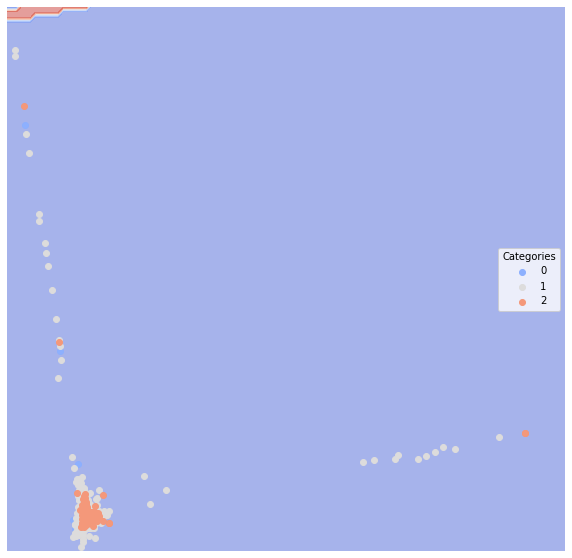

In [144]:
lucem_illud_2020.plotregions(clf, test_data_df)

In [145]:
#Create vectors for extrapolation
TFVects_out = TFVectorizer.transform(extrapolation[text_col])
extrapolation[vec_col] = [np.array(v).flatten() for v in TFVects_out.todense()]

#Add to df
extrapolation['dt_predict'] = clf.predict(np.stack(extrapolation[vec_col], axis=0))
extrapolation[[text_col, 'dt_predict']]

,tweet,dt_predict
5149,@TielerMLG @psvch @HalfAssed_ coming to the re...,1
5150,"@TimMurphyy @fgcu_basketball rather be an ""ult...",1
5151,"@TimoteoSHonesto @vcortesusmc little punk, we ...",1
5152,@TinnyTimm taylor wack ass bitch nigga,1
5153,@Titan21Mtzzz vegeta is a little bitch #TeamGoku,1
5154,@Titan21Mtzzz you is a hoe,1
5155,@Titan4Ever2488 how are Yankees games on the r...,2
5156,@Titan4Ever2488 how do Yankees fans look back ...,2
5157,@Titan4Ever2488 some Mets fan tried telling me...,2
5158,@TitsOfAnarchy \nI glads dis colored man cans ...,1


### Random Forest

In [147]:
# Train Random Forest
clf = sklearn.ensemble.RandomForestClassifier()

In [148]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [149]:
# Save Predictions
train_data_df['rf_predict'] = clf.predict(np.stack(train_data_df[vec_col], axis=0))
print("Training score:")
print(clf.score(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col]))

Training score:
0.994


In [150]:
#Create vectors for test
TFVects_test = TFVectorizer.transform(test_data_df[text_col])
test_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['rf_predict'] = clf.predict(np.stack(test_data_df[vec_col], axis=0))

#Test
print("Testing score:")
print(clf.score(np.stack(test_data_df[vec_col], axis=0), test_data_df[label_col]))

Testing score:
0.815


In [151]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.072,0.584014,0.481481,0.146159,0.183099
1,0.181,0.691322,0.829240,0.825230,0.952957
2,0.117,0.736014,0.788136,0.488198,0.502703


In [152]:
test_data_df.groupby('rf_predict').size()

rf_predict
0     27
1    855
2    118
dtype: int64

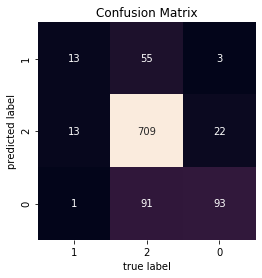

In [153]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

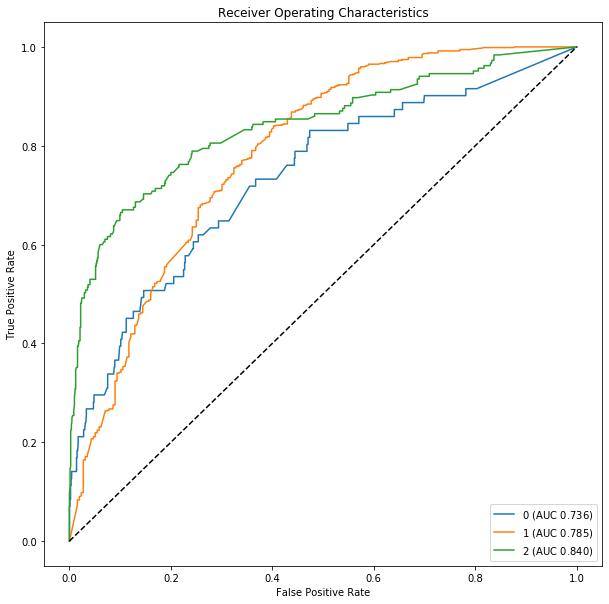

In [154]:
lucem_illud_2020.plotMultiROC(clf, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


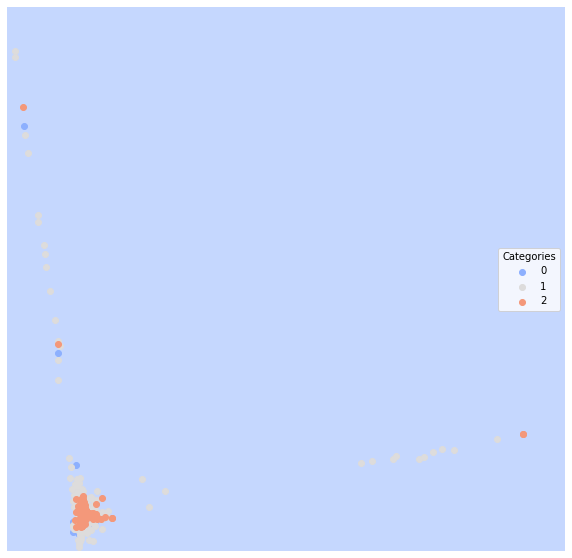

In [155]:
lucem_illud_2020.plotregions(clf, test_data_df)

In [156]:
#Create vectors for extrapolation
TFVects_out = TFVectorizer.transform(extrapolation[text_col])
extrapolation[vec_col] = [np.array(v).flatten() for v in TFVects_out.todense()]

#Add to df
extrapolation['rf_predict'] = clf.predict(np.stack(extrapolation[vec_col], axis=0))
extrapolation[[text_col, 'rf_predict']]

,tweet,rf_predict
5149,@TielerMLG @psvch @HalfAssed_ coming to the re...,1
5150,"@TimMurphyy @fgcu_basketball rather be an ""ult...",1
5151,"@TimoteoSHonesto @vcortesusmc little punk, we ...",1
5152,@TinnyTimm taylor wack ass bitch nigga,1
5153,@Titan21Mtzzz vegeta is a little bitch #TeamGoku,1
5154,@Titan21Mtzzz you is a hoe,1
5155,@Titan4Ever2488 how are Yankees games on the r...,2
5156,@Titan4Ever2488 how do Yankees fans look back ...,2
5157,@Titan4Ever2488 some Mets fan tried telling me...,2
5158,@TitsOfAnarchy \nI glads dis colored man cans ...,2


### RF - by bagging decision trees

In [157]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=5) #Create an instance of our decision tree classifier.
clf = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [158]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col])

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
   

In [159]:
# Save Predictions
train_data_df['bagtree_predict'] = clf.predict(np.stack(train_data_df[vec_col], axis=0))
print("Training score:")
print(clf.score(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col]))

Training score:
0.798


In [160]:
#Create vectors for test
TFVects_test = TFVectorizer.transform(test_data_df[text_col])
test_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['bagtree_predict'] = clf.predict(np.stack(test_data_df[vec_col], axis=0))

#Test
print("Testing score:")
print(clf.score(np.stack(test_data_df[vec_col], axis=0), test_data_df[label_col]))

Testing score:
0.792


In [161]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.071,0.500000,0.000000,0.071000,0.000000
1,0.207,0.603390,0.785942,0.785604,0.991935
2,0.138,0.641651,0.885246,0.389396,0.291892


In [162]:
test_data_df.groupby('bagtree_predict').size()

bagtree_predict
1    939
2     61
dtype: int64

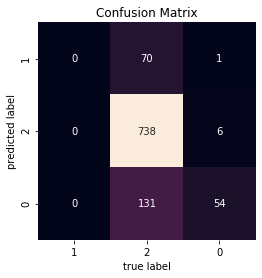

In [163]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

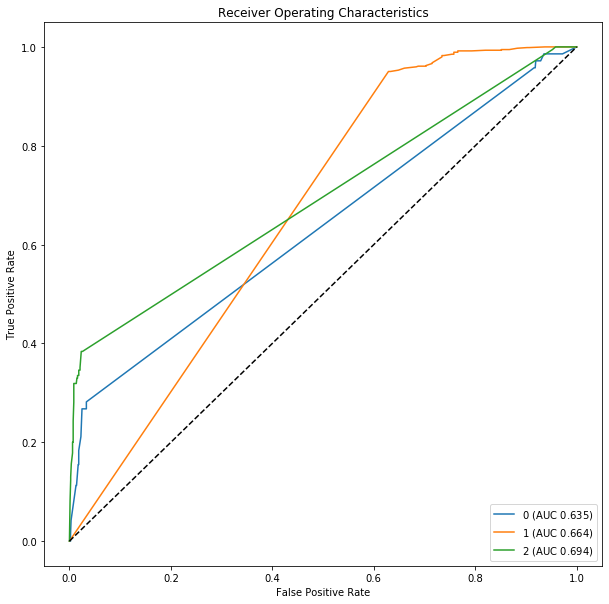

In [164]:
lucem_illud_2020.plotMultiROC(clf, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


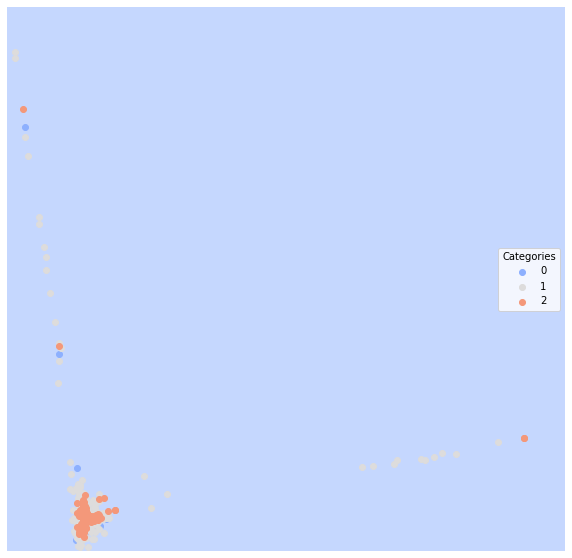

In [165]:
lucem_illud_2020.plotregions(clf, test_data_df)

In [166]:
#Create vectors for extrapolation
TFVects_out = TFVectorizer.transform(extrapolation[text_col])
extrapolation[vec_col] = [np.array(v).flatten() for v in TFVects_out.todense()]

#Add to df
extrapolation['bagtree_predict'] = clf.predict(np.stack(extrapolation[vec_col], axis=0))
extrapolation[[text_col, 'bagtree_predict']]

,tweet,bagtree_predict
5149,@TielerMLG @psvch @HalfAssed_ coming to the re...,1
5150,"@TimMurphyy @fgcu_basketball rather be an ""ult...",1
5151,"@TimoteoSHonesto @vcortesusmc little punk, we ...",1
5152,@TinnyTimm taylor wack ass bitch nigga,1
5153,@Titan21Mtzzz vegeta is a little bitch #TeamGoku,1
5154,@Titan21Mtzzz you is a hoe,1
5155,@Titan4Ever2488 how are Yankees games on the r...,2
5156,@Titan4Ever2488 how do Yankees fans look back ...,2
5157,@Titan4Ever2488 some Mets fan tried telling me...,2
5158,@TitsOfAnarchy \nI glads dis colored man cans ...,1


It is interesting to note the larger discrepancy score for these tree models between the training and testing score. This is likely due to the tendency of the model to overfit if not pruned appropriately. Comparing the unpruned decision tree and the random forest ensemble model, we can see that the training and test score gap has decreased. This shows that the ensemble tries to reduce the variance of the model.

In fact when bagging decision trees manually and choosing to input a max depth parameter of 5, to reduce danger of overfitting, the training and testing score gap is reduced much further.

All of these 3 models were able to identify offensive speech (Category 1) pretty well, but were less able to identify the hate speech and neither category with low recall scores.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [167]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, better..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[m, sorry, read, commandment]"


Make a testing and training set:

In [168]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [169]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [170]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [171]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [172]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
sci.space,0.411492,0.575768,0.344828,0.313530,0.547368
talk.religion.misc,0.320952,0.626175,0.293103,0.242188,0.543131
soc.religion.christian,0.271619,0.502128,1.000000,0.275875,0.004255
comp.graphics,0.304121,0.587711,0.423773,0.324155,0.352688


And lets look at the testing data

In [173]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.27209302325581397


Let's produce another confusion matrix:

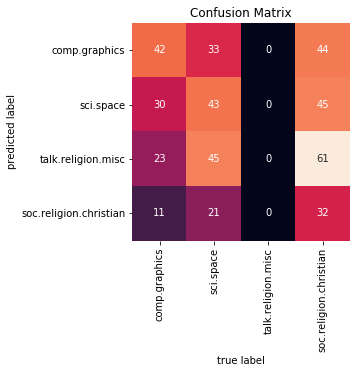

In [174]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

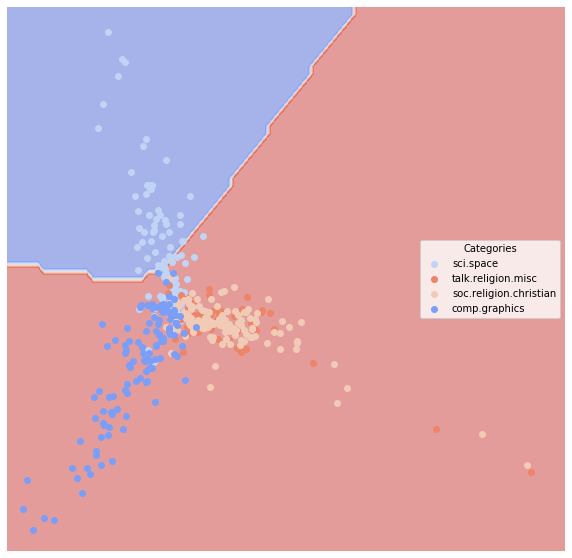

In [175]:
lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [176]:
#Train model
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

In [177]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [178]:
# Save Predictions
train_data_df['knn_predict'] = clf.predict(np.stack(train_data_df[vec_col], axis=0))
print("Training score:")
print(clf.score(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col]))

Training score:
0.99425


In [179]:
#Create vectors for test
TFVects_test = TFVectorizer.transform(test_data_df[text_col])
test_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['knn_predict'] = clf.predict(np.stack(test_data_df[vec_col], axis=0))

#Test
print("Testing score:")
print(clf.score(np.stack(test_data_df[vec_col], axis=0), test_data_df[label_col]))

Testing score:
0.757


In [180]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.071,0.526016,0.500000,0.095169,0.056338
1,0.243,0.534358,0.757451,0.757325,0.990591
2,0.172,0.541403,0.842105,0.241831,0.086486


In [181]:
test_data_df.groupby('knn_predict').size()

knn_predict
0      8
1    973
2     19
dtype: int64

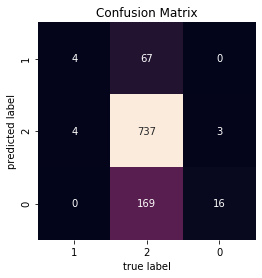

In [182]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

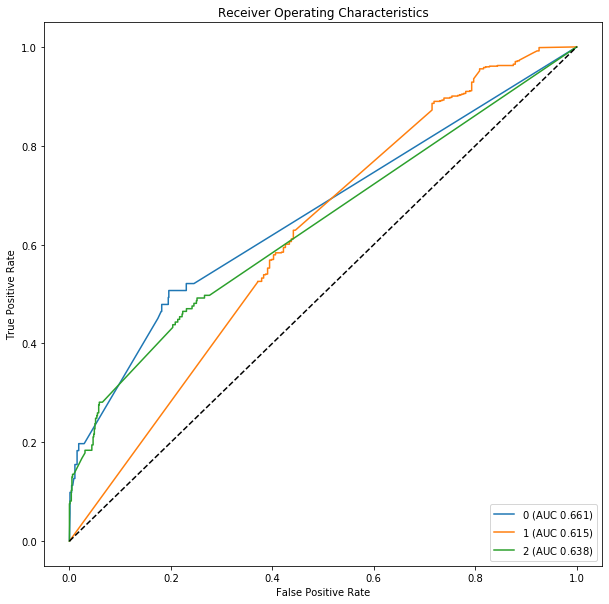

In [183]:
lucem_illud_2020.plotMultiROC(clf, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


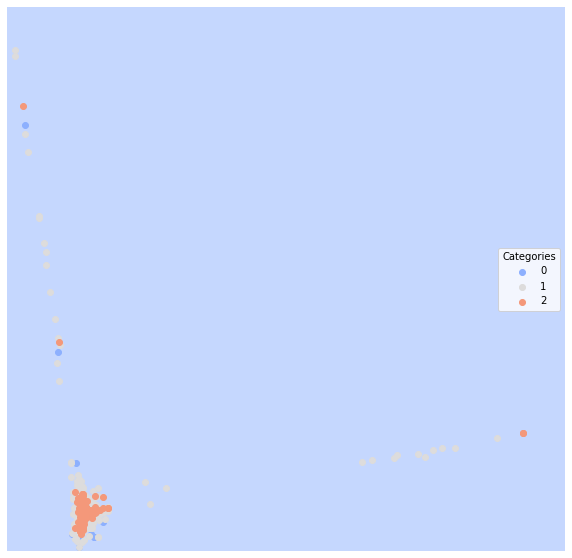

In [184]:
lucem_illud_2020.plotregions(clf, test_data_df)

In [185]:
#Create vectors for extrapolation
TFVects_out = TFVectorizer.transform(extrapolation[text_col])
extrapolation[vec_col] = [np.array(v).flatten() for v in TFVects_out.todense()]

#Add to df
extrapolation['knn_predict'] = clf.predict(np.stack(extrapolation[vec_col], axis=0))
extrapolation[[text_col, 'knn_predict']]

,tweet,knn_predict
5149,@TielerMLG @psvch @HalfAssed_ coming to the re...,1
5150,"@TimMurphyy @fgcu_basketball rather be an ""ult...",1
5151,"@TimoteoSHonesto @vcortesusmc little punk, we ...",1
5152,@TinnyTimm taylor wack ass bitch nigga,1
5153,@Titan21Mtzzz vegeta is a little bitch #TeamGoku,1
5154,@Titan21Mtzzz you is a hoe,1
5155,@Titan4Ever2488 how are Yankees games on the r...,1
5156,@Titan4Ever2488 how do Yankees fans look back ...,1
5157,@Titan4Ever2488 some Mets fan tried telling me...,1
5158,@TitsOfAnarchy \nI glads dis colored man cans ...,1


The k-nearest neighbor model does really well on the training score unsurprisingly since it fit the model to the points and used these same points to predict their classes. The training and test score discrepancy is also evident here suggesting the danger of overfitting. Similar to other models, it is able to pick up offensive language (category 1) but does not perform as well for the other 2 categories in recall metric which is of a greater concern in this model.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [186]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [187]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [188]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [189]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

...and consider the results:

In [190]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.003135,0.997899,0.987805,0.987805,1.000000
Relationships,0.028213,0.954078,0.974684,0.915403,0.916667
Weeaboo Tales: stories about the extreme fans of japanese culture,0.000000,1.000000,1.000000,1.000000,1.000000
Bad Roommates: Tales of Irritation,0.025078,0.975240,0.931034,0.914870,0.975904


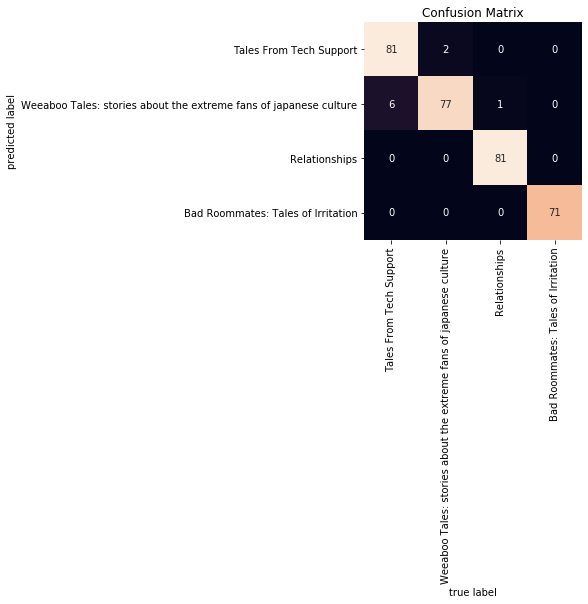

In [191]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

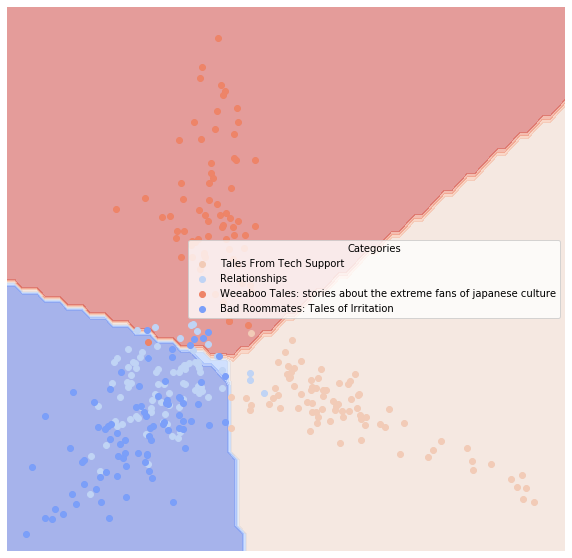

In [192]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [193]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [194]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.009404,0.989625,0.975610,0.966700,0.987654
Relationships,0.037618,0.940046,0.961538,0.886730,0.892857
Weeaboo Tales: stories about the extreme fans of japanese culture,0.006270,0.995968,0.972603,0.972603,1.000000
Bad Roommates: Tales of Irritation,0.040752,0.952930,0.906977,0.868014,0.939759


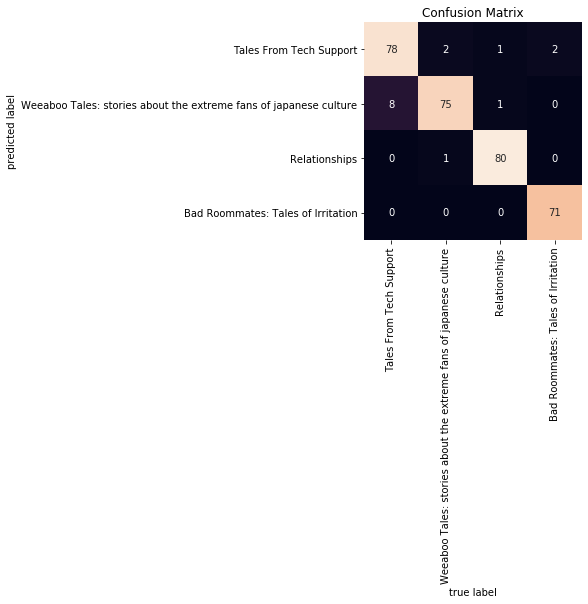

In [195]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

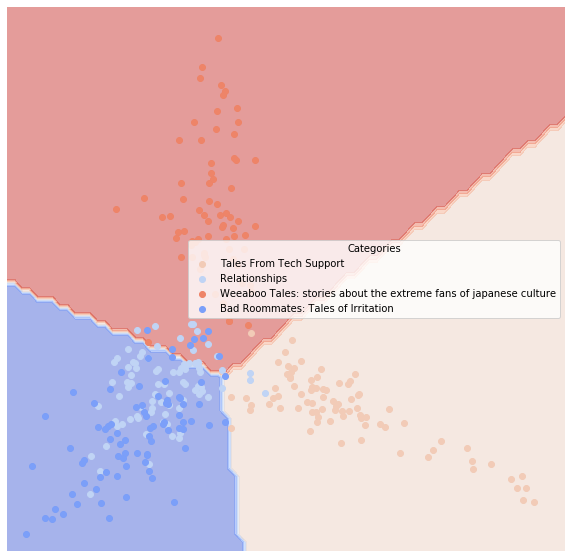

In [196]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [197]:
# Train Neural Networks
clf = sklearn.neural_network.MLPClassifier()

In [198]:
clf.fit(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [199]:
# Save Predictions
train_data_df['nn_predict'] = clf.predict(np.stack(train_data_df[vec_col], axis=0))
print("Training score:")
print(clf.score(np.stack(train_data_df[vec_col], axis=0), train_data_df[label_col]))

Training score:
0.99425


In [200]:
#Create vectors for test
TFVects_test = TFVectorizer.transform(test_data_df[text_col])
test_data_df[vec_col] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['nn_predict'] = clf.predict(np.stack(test_data_df[vec_col], axis=0))

#Test
print("Testing score:")
print(clf.score(np.stack(test_data_df[vec_col], axis=0), test_data_df[label_col]))

Testing score:
0.752


In [201]:
lucem_illud_2020.evaluateClassifier(clf, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.096,0.623130,0.313433,0.142705,0.295775
1,0.239,0.670279,0.828349,0.816218,0.856183
2,0.161,0.711109,0.573171,0.382233,0.508108


In [202]:
test_data_df.groupby('nn_predict').size()

nn_predict
0     67
1    769
2    164
dtype: int64

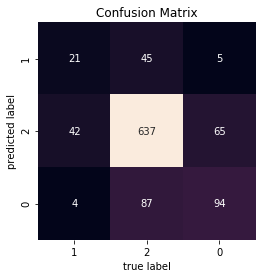

In [203]:
lucem_illud_2020.plotConfusionMatrix(clf, test_data_df)

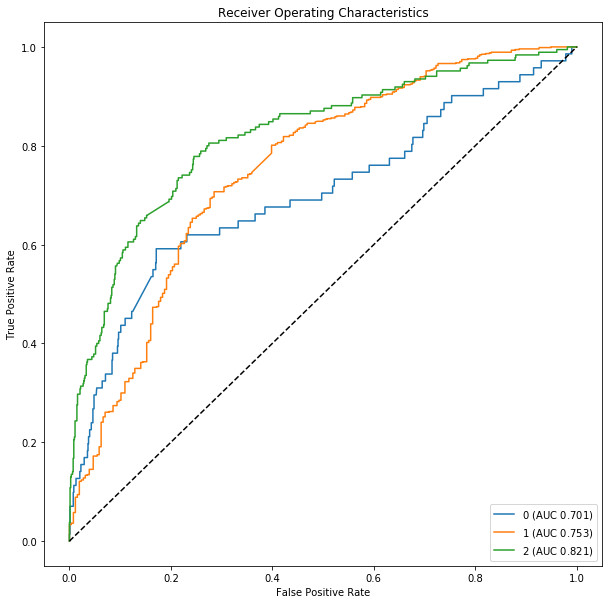

In [204]:
lucem_illud_2020.plotMultiROC(clf, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


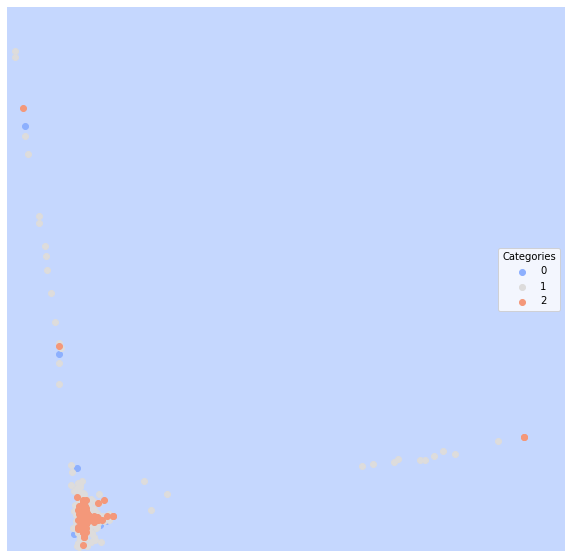

In [205]:
lucem_illud_2020.plotregions(clf, test_data_df)

In [206]:
#Create vectors for extrapolation
TFVects_out = TFVectorizer.transform(extrapolation[text_col])
extrapolation[vec_col] = [np.array(v).flatten() for v in TFVects_out.todense()]

#Add to df
extrapolation['nn_predict'] = clf.predict(np.stack(extrapolation[vec_col], axis=0))
extrapolation[[text_col, 'nn_predict']]

,tweet,nn_predict
5149,@TielerMLG @psvch @HalfAssed_ coming to the re...,0
5150,"@TimMurphyy @fgcu_basketball rather be an ""ult...",1
5151,"@TimoteoSHonesto @vcortesusmc little punk, we ...",1
5152,@TinnyTimm taylor wack ass bitch nigga,1
5153,@Titan21Mtzzz vegeta is a little bitch #TeamGoku,1
5154,@Titan21Mtzzz you is a hoe,1
5155,@Titan4Ever2488 how are Yankees games on the r...,2
5156,@Titan4Ever2488 how do Yankees fans look back ...,2
5157,@Titan4Ever2488 some Mets fan tried telling me...,2
5158,@TitsOfAnarchy \nI glads dis colored man cans ...,1


Overall, we see the same pattern of the evaluation metrics across the 3 categories for all models, likely due to the label distribution. The offensive language category performed well on most models, but the performance for the other 2 categories were much poorer especially looking at the recall metric. 

If we were just looking to identify offensive language alone, the logistic regression, naive bayes and k-nearest neighbor models have almost perfect recall scores. However, given the uneven label distribution in this data, we could achieve good performance metrics just by predicting everything as category 1. Hence, I also calculated the best models based on average recall metrics of the 3 categories were the neural networks and decision tree classifier, having an average recall score of about 0.553 and 0.577 respectively. 